In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib
import matplotlib.pyplot as plt
sns.set_context("notebook")

In [2]:
def method_name(s: pd.Series) -> str:
    if s.method == "empty":
        return "empty"
    if s.method == "dense":
        return f"attn-{s.kernel}"
    if s.method == "sparq":
        return "sparq-" + {
            ("vanilla", "torch"): "vanilla",
            ("vanilla", "custom"): "triton",
            ("compiled", "torch"): "compiled",
        }[(s.kernel, s.gather_matmul)]

def theoretical_bytes(s: pd.Series) -> int:
    dsize = dict(float16=2, float32=4)[s["dtype"]]
    if s.method == "empty":
        return 0
    if s.method == "dense":
        return dsize * s.batch_size * s.n_head * (2 * s.sequence_length * s.head_dim)
    if s.method == "sparq":
        return dsize * s.batch_size * s.n_head * (s.k1 * s.sequence_length + 2 * s.k2 * s.head_dim)

df = (pd.read_json("20240114_sweep_a100.jsonl", lines=True)
    .pipe(lambda d: d.assign(
        duration=d.duration.apply(lambda s: np.mean(s) if s else np.nan),
        duration_stderr=d.duration.apply(lambda s: np.std(s) / len(s)**.5 if s else np.nan),
    ))
    [["method", "batch_size", "n_head", "sequence_length", "head_dim", "dtype", "k1", "k2", "kernel", "gather_matmul", "store_k_twice", "duration", "duration_stderr"]]
    .pipe(lambda d: d.assign(
        name=d.apply(method_name, axis=1),
        duration_per_q=d.duration/d.batch_size,
        duration_per_q_stderr=d.duration_stderr/d.batch_size,
        duration_per_qc=d.duration/d.batch_size/d.sequence_length,
        duration_per_qc_stderr=d.duration_stderr/d.batch_size/d.sequence_length,
        theoretical_bytes=d.apply(theoretical_bytes, axis=1),
    ))
    .pipe(lambda d: d.assign(achieved_bandwidth=d.theoretical_bytes/d.duration))
)
df.head()

,method,batch_size,n_head,sequence_length,head_dim,dtype,k1,k2,kernel,gather_matmul,store_k_twice,duration,duration_stderr,name,duration_per_q,duration_per_q_stderr,duration_per_qc,duration_per_qc_stderr,theoretical_bytes,achieved_bandwidth
0,empty,1,32,2048,128,float16,NaN,NaN,empty,None,NaN,0.000009,2.220479e-08,empty,0.000009,2.220479e-08,4.541944e-09,1.084218e-11,0.0,0.000000e+00
1,dense,1,32,2048,128,float16,NaN,NaN,vanilla,None,NaN,0.000095,1.117008e-07,attn-vanilla,0.000095,1.117008e-07,4.616042e-08,5.454140e-11,33554432.0,3.549361e+11
2,dense,1,32,2048,128,float16,NaN,NaN,compiled,None,NaN,0.000156,1.770082e-07,attn-compiled,0.000156,1.770082e-07,7.628987e-08,8.642980e-11,33554432.0,2.147598e+11
3,dense,1,32,2048,128,float16,NaN,NaN,flash,None,NaN,0.000167,1.175653e-07,attn-flash,0.000167,1.175653e-07,8.135801e-08,5.740491e-11,33554432.0,2.013815e+11
4,dense,1,32,2048,128,float16,NaN,NaN,math,None,NaN,0.000109,3.939716e-07,attn-math,0.000109,3.939716e-07,5.309994e-08,1.923689e-10,33554432.0,3.085503e+11


# Key figures

In [9]:
k1, k2, batch_size, sequence_length = 32, 64, 64, 4096   # SHOWN
# k1, k2, batch_size, sequence_length = 16, 64, 64, 4096
# k1, k2, batch_size, sequence_length = 16, 64, 16, 16384
# k1, k2, batch_size, sequence_length = 16, 64, 4, 65536

d = (df
    .pipe(lambda d: d[(d.method=="dense")|((d.k1==k1) & (d.k2==k2))])
    .pipe(lambda d: d[(d.batch_size==batch_size)&(d.sequence_length==sequence_length)])
    .pipe(lambda d: d[~d.name.isin(["attn-flash", "attn-math"])])
    .pipe(lambda d: d.assign(name=d.apply(lambda s: s["name"] + ("-single-K" if s.store_k_twice == 0 else ""), axis=1)))
    .pipe(lambda d: d.assign(speedup=d[d.method=="dense"].duration_per_q.min() / d.duration_per_q))
    .pipe(lambda d: d.assign(theoretical_speedup=d[d.method=="dense"].theoretical_bytes.min() / d.theoretical_bytes))
)

print(f"# k1={k1}, k2={k2}, batch_size={batch_size}, sequence_length={sequence_length}")
(d.sort_values("duration", ascending=False)
    .rename(columns=dict(duration_per_q_stderr="stderr"))
    [["name", "duration_per_q", "speedup", "theoretical_speedup", "stderr"]]
    .style
    .format(dict(duration_per_q=lambda x: f"{x*1e6:.1f} us", stderr=lambda x: f"{x*1e6:.2f} us",
        speedup="{:.2f}", theoretical_speedup="{:.1f}"
    ))
    .hide()
)

# k1=32, k2=64, batch_size=64, sequence_length=4096


name,duration_per_q,speedup,theoretical_speedup,stderr
sparq-vanilla,52.6 us,0.93,7.1,0.30 us
sparq-vanilla-single-K,50.2 us,0.98,7.1,0.10 us
attn-mem_efficient,49.7 us,0.98,1.0,0.01 us
attn-compiled,49.2 us,0.99,1.0,0.02 us
attn-vanilla,48.9 us,1.00,1.0,0.01 us
sparq-compiled-single-K,46.9 us,1.04,7.1,0.24 us
sparq-triton-single-K,36.8 us,1.33,7.1,0.08 us
sparq-compiled,32.0 us,1.53,7.1,0.01 us
sparq-triton,15.8 us,3.10,7.1,0.00 us


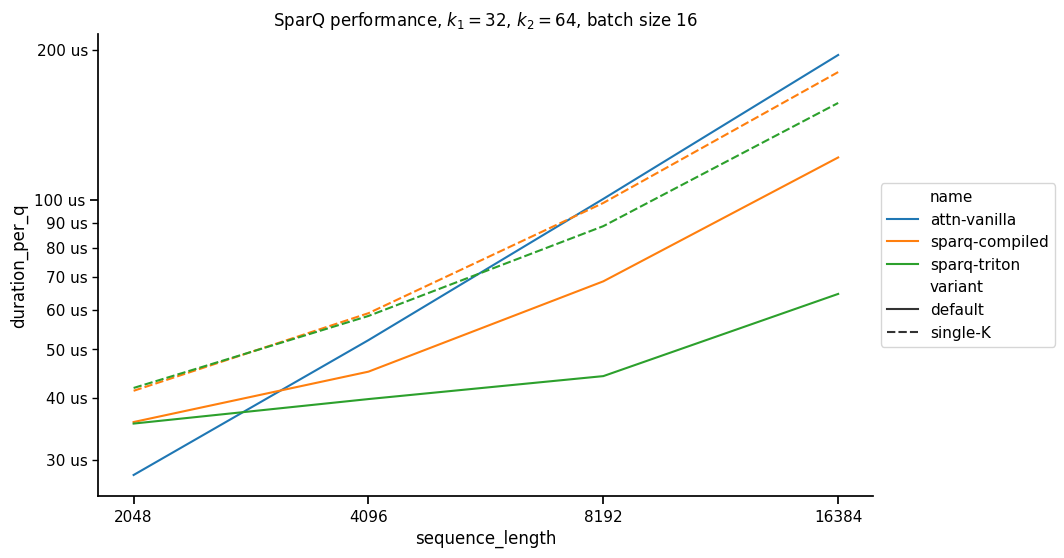

In [14]:
d = (df
    .pipe(lambda d: d[(d.method=="dense")|((d.k1==32) & (d.k2==64))])
    .pipe(lambda d: d[(d.batch_size==16)])
    .pipe(lambda d: d[(d.sequence_length<=16384)])
    .pipe(lambda d: d[~d.name.isin(["attn-flash", "attn-math", "attn-mem_efficient", "attn-compiled", "sparq-vanilla"])])
    .pipe(lambda d: d.assign(variant=d.fillna(0).apply(lambda s: {("dense", 0): "default", ("sparq", 0): "single-K", ("sparq", 1): "default"}[(s.method, s.store_k_twice or 0)], axis=1)))
)

plt.figure(figsize=(10, 6))
ax = sns.lineplot(data=d, y="duration_per_q", x="sequence_length", hue="name", style="variant")
ax.set_xscale("log", base=2)
ax.set_yscale("log")
ax.xaxis.set_major_formatter("{x:.0f}")
ax.legend(bbox_to_anchor=(1, 0.5), loc="center left")
ax.yaxis.set_major_formatter(lambda x, _: f"{x*1e6:.0f} us")
ax.yaxis.set_minor_formatter(lambda x, _: f"{x*1e6:.0f} us")
ax.set_title("SparQ performance, $k_1=32$, $k_2=64$, batch size 16")
sns.despine(ax=ax)

# Exploration

In [17]:
(df.pipe(lambda d: d[d.method=="sparq"])
    .pipe(lambda d: d[d.batch_size==16])
    .pipe(lambda d: d[d.k1==16])
    .pivot_table(index=["batch_size", "k1", "sequence_length", "k2"], columns=["store_k_twice", "kernel", "gather_matmul"], values="duration_per_qc")
    .apply(lambda x: x*1e9)
    .style
    .format("{:.0f}")
    .background_gradient(axis=None)
)

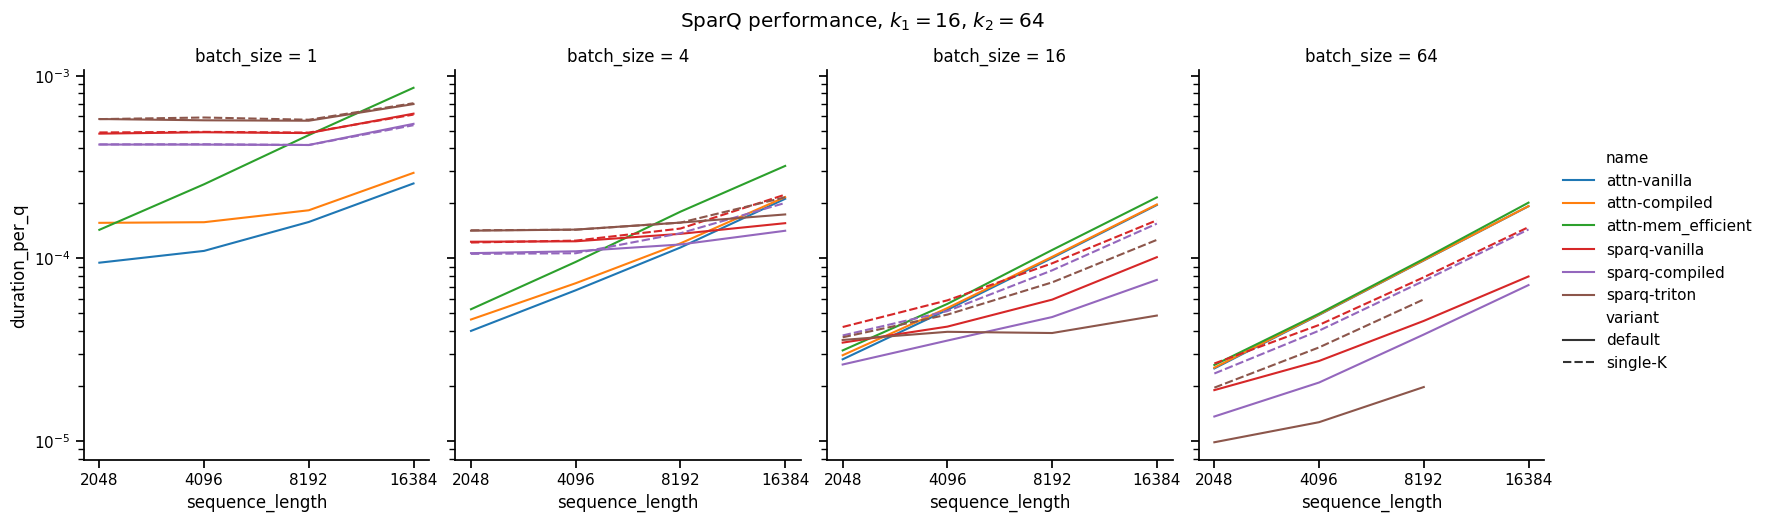

In [24]:
d = (df
    .pipe(lambda d: d[(d.method=="dense")|((d.k1==16) & (d.k2==64))])
    .pipe(lambda d: d[(d.sequence_length<=16384)])
    .pipe(lambda d: d[~d.name.isin(["attn-flash", "attn-math"])])
    .pipe(lambda d: d.assign(variant=d.fillna(0).apply(lambda s: {("dense", 0): "default", ("sparq", 0): "single-K", ("sparq", 1): "default"}[(s.method, s.store_k_twice or 0)], axis=1)))
)
# display(d)
g = sns.relplot(data=d, y="duration_per_q", x="sequence_length", hue="name", style="variant",
    col="batch_size", kind="line", aspect=0.8)
for b, ax in g.axes_dict.items():
    ax.set_xscale("log", base=2)
    ax.set_yscale("log")
    ax.xaxis.set_major_formatter("{x:.0f}")
plt.suptitle("SparQ performance, $k_1=16$, $k_2=64$", y=1.04);

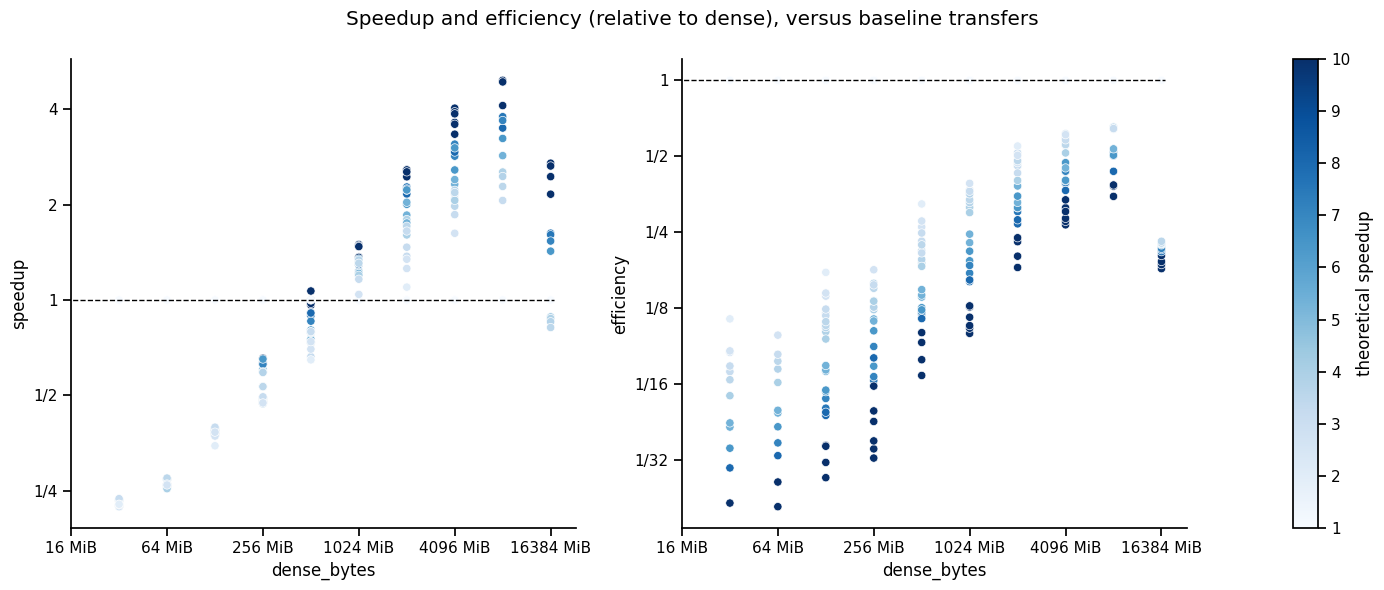

In [21]:
best = (df
    .groupby(["batch_size", "n_head", "sequence_length", "method", "k1", "k2"], dropna=False)
    .apply(lambda d: d.iloc[d.duration.argmin()])
    .reset_index(drop=True)
)

def get_speedup(d: pd.DataFrame) -> pd.DataFrame:
    dense = d[d.method=="dense"].iloc[0]
    return d[["k1", "k2"]].assign(
        dense_bytes=dense.theoretical_bytes,
        speedup=dense.duration/d.duration,
        theoretical_speedup=dense.theoretical_bytes/d.theoretical_bytes,
    )

speedup = (best
    .pipe(lambda d: d[d.method!="empty"])
    .pipe(lambda d: d[(d.sequence_length<=16384)])
    .groupby(["batch_size", "n_head", "sequence_length"]).apply(get_speedup)
    .pipe(lambda d: d.assign(efficiency=d.speedup/d.theoretical_speedup))
    .reset_index().drop(columns="level_3")
)

fig, axs = plt.subplots(1, 3, figsize=(14, 6), gridspec_kw=dict(width_ratios=[1, 1, 0.05]))
cmap, norm = "Blues", matplotlib.colors.Normalize(vmin=1, vmax=10)
sns.scatterplot(data=speedup, y="speedup", x="dense_bytes", hue="theoretical_speedup", hue_norm=norm, palette=cmap, ax=axs[0], legend=False)
sns.scatterplot(data=speedup, y="efficiency", x="dense_bytes", hue="theoretical_speedup", hue_norm=norm, palette=cmap, ax=axs[1], legend=False)
for ax in axs[:-1]:
    ax.hlines(1, *ax.get_xlim(), "k", "--", lw=1)
    ax.set_xscale("log", base=2)
    ax.set_yscale("log", base=2)
    ax.set_xticks([2**n for n in [24, 26, 28, 30, 32, 34]])
    ax.xaxis.set_major_formatter(lambda x, _: f"{x/2**20:.0f} MiB")
    ax.yaxis.set_major_formatter(lambda x, _: f"{x:.0f}" if x >= 1 else f"1/{1/x:.0f}")
    sns.despine(ax=ax)
fig.colorbar(plt.cm.ScalarMappable(cmap=cmap, norm=norm), label="theoretical speedup", cax=axs[2])
plt.suptitle("Speedup and efficiency (relative to dense), versus baseline transfers")
plt.tight_layout()

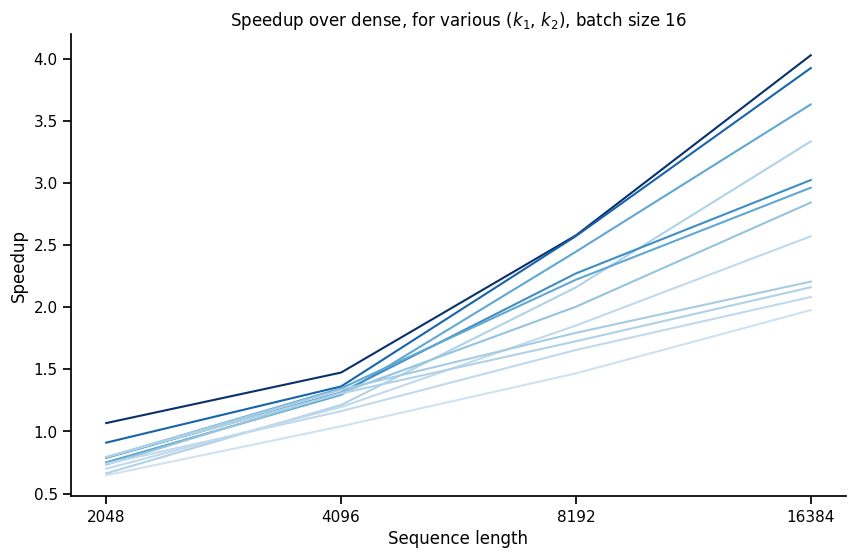

In [22]:
plt.figure(figsize=(10, 6))
ax = plt.gca()
for _, s in speedup.pipe(lambda d: d[d.batch_size==16]).groupby(["k1", "k2"]):
    ax.plot(s.sequence_length, s.speedup, color=matplotlib.cm.Blues(s.theoretical_speedup.iloc[0]/10))
ax.set_xscale("log", base=2)
ax.set_ylabel("Speedup")
ax.set_xlabel("Sequence length")
ax.xaxis.set_major_formatter("{x:.0f}")
ax.set_title("Speedup over dense, for various ($k_1$, $k_2$), batch size 16")
sns.despine(ax=ax)